In [1]:
import configparser

import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

In [2]:
parser = configparser.ConfigParser()
parser.read('database.ini')

db_password = parser['psql']['password']

In [3]:
query = '''
SELECT * 
FROM dj_hetmech_app_degreegroupedpermutation dgp
WHERE (dgp.metapath_id='CtDrD')
'''
connection = psycopg2.connect(host = 'hetmech-db-dev.cobepk65dd7j.us-east-1.rds.amazonaws.com', 
                              database = 'dj_hetmech', user = 'read_only_user', password = db_password)

ctdrd_df = pd.read_sql(query, connection)

In [4]:
ctdrd_df['p_nz'] = ctdrd_df['n_nonzero_dwpcs'] / ctdrd_df['n_dwpcs']
ctdrd_df['beta'] = ctdrd_df['nonzero_mean'] / ctdrd_df['nonzero_sd']**2
ctdrd_df['alpha'] = ctdrd_df['beta'] * ctdrd_df['nonzero_mean']

In [5]:
# Check no duplicates (1 indicates no duplicates) so that we can use "sum" to aggregate below

ctdrd_df.groupby(['source_degree', 'target_degree'], as_index=False).size().max()

1

In [6]:
nz_df = pd.crosstab(ctdrd_df['source_degree'], ctdrd_df['target_degree'], ctdrd_df['p_nz'], aggfunc=sum)
alpha_df = pd.crosstab(ctdrd_df['source_degree'], ctdrd_df['target_degree'], ctdrd_df['alpha'], aggfunc=sum)
beta_df = pd.crosstab(ctdrd_df['source_degree'], ctdrd_df['target_degree'], ctdrd_df['beta'], aggfunc=sum)

Text(0, 0.5, 'source degree')

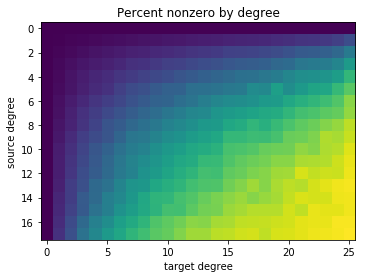

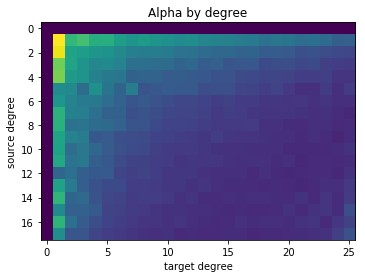

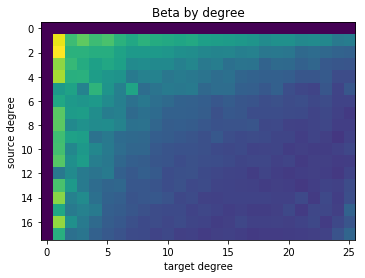

In [7]:
plt.figure()
plt.imshow(nz_df.values)
plt.title('Percent nonzero by degree')
plt.xlabel('target degree')
plt.ylabel('source degree')

plt.figure()
plt.imshow(alpha_df.values)
plt.title('Alpha by degree')
plt.xlabel('target degree')
plt.ylabel('source degree')

plt.figure()
plt.imshow(beta_df.values)
plt.title('Beta by degree')
plt.xlabel('target degree')
plt.ylabel('source degree')